# Data Gathering

## Calling in Data

In [138]:
import pandas as pd
from datetime import datetime, timedelta

start_date = datetime(2019, 1, 1)
end_date = datetime(2020, 3, 31)

date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

unique_yyyymm_values = sorted(list(set(date.strftime('%Y%m') for date in date_range)))

for i in unique_yyyymm_values:
    variable_name = f"df_{i}"
    globals()[variable_name] = pd.read_csv(f'../Data/part1/{i}-capitalbikeshare-tripdata.csv')


In [139]:
import pandas as pd
from datetime import datetime, timedelta

start_date = datetime(2020, 4, 1)
end_date = datetime(2022, 12, 31)

date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

unique_yyyymm_values = sorted(list(set(date.strftime('%Y%m') for date in date_range)))

for i in unique_yyyymm_values:
    variable_name = f"df_{i}"
    globals()[variable_name] = pd.read_csv(f'../Data/part2/{i}-capitalbikeshare-tripdata.csv')


C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13920\2732659076.py:13: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  globals()[variable_name] = pd.read_csv(f'../Data/part2/{i}-capitalbikeshare-tripdata.csv')


In [140]:
result_list = []

for i in unique_yyyymm_values:
    df_name = f'df_{i}'
    columns_len = len(locals()[df_name].columns)
    result_list.append(columns_len)

set(result_list)

{13}

In [141]:
print("Columns for dataset 201901 - 202003")
print(df_201901.columns)
print("")
print("Columns for dataset 202004 - 202212")
print(df_202012.columns)

Columns for dataset 201901 - 202003
Index(['Duration', 'Start date', 'End date', 'Start station number',
       'Start station', 'End station number', 'End station', 'Bike number',
       'Member type'],
      dtype='object')

Columns for dataset 202004 - 202212
Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')


### Merging Datasets

In [142]:
start_date = datetime(2019, 1, 1)
end_date = datetime(2022, 12, 31)

date_range = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]

unique_yyyymm_values = sorted(list(set(date.strftime('%Y%m') for date in date_range)))

# Match column names for all datasets and drop na values
for i in unique_yyyymm_values:
    variable_name = f"df_{i}"
    if len(globals()[variable_name].columns) == 9:
        globals()[variable_name].rename(columns={
            'Duration':'Duration', 
            'Start date':'started_at', 
            'End date':'ended_at',
            'Start station number':'start_station_id',
            'Start station':'start_station_name', 
            'End station number':'end_station_id', 
            'End station':'end_station_name', 
            'Bike number':'Bike number',
            'Member type':'member_casual'
        }, inplace=True)
    else:
        pass
    globals()[variable_name].dropna()

In [143]:
merge_df = df_201901.copy()

for i in unique_yyyymm_values[1:]:
    variable_name = f"df_{i}"
    merge_df = pd.concat([merge_df,globals()[variable_name]],ignore_index=True, sort=False)

In [144]:
merge_df = merge_df.drop(['ride_id','rideable_type','Bike number'],axis=1)

## Cleaning Data

In [145]:
# Calculating Miles

from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Radius of the Earth in miles (mean value)
    radius = 3959.0

    # Calculate the distance
    distance = radius * c

    return distance


In [177]:
# Add duration in seconds
merge_df['ended_at'] = pd.to_datetime(merge_df['ended_at'])
merge_df['started_at'] = pd.to_datetime(merge_df['started_at'])
merge_df['Duration'] = merge_df['ended_at']-merge_df['started_at']
merge_df['Duration'] = merge_df['Duration'].dt.total_seconds()

# Add Year/Month/Day column
merge_df['Year'] = merge_df['started_at'].dt.year
merge_df['Month'] = merge_df['started_at'].dt.month
merge_df['Day'] = merge_df['started_at'].dt.day
merge_df['Hour'] = merge_df['started_at'].dt.hour

# Change member column to lower case to unify format
merge_df.member_casual = merge_df.member_casual.str.lower()

# Eliminate Duration less than 0
merge_df = merge_df[~(merge_df['Duration'] < 0)]

In [178]:
# starting IDs that can't be matched
start_empty = merge_df[merge_df.start_lat.isna() | merge_df.start_lng.isna()]
start_not_empty = merge_df[merge_df.start_lat.notna() & merge_df.start_lng.notna()]

start_a = set(start_empty.start_station_id)
start_b = set(start_not_empty.start_station_id)

# ending IDs that can't be matched
end_empty = merge_df[merge_df.end_lat.isna() | merge_df.end_lng.isna()]
end_not_empty = merge_df[merge_df.end_lat.notna() & merge_df.end_lng.notna()]

end_a = set(end_empty.start_station_id)
end_b = set(end_not_empty.start_station_id)

# Take out stations that don't have a longitude and latitude
merge_df = merge_df[~merge_df['start_station_id'].isin(list((start_a-start_b) | (end_a-end_b)))]

In [179]:
# fill in station latitude longitude missing values for 2019

station_index = merge_df[merge_df.start_lat.notna()].groupby('start_station_id')[['start_lat','start_lng']].first().reset_index()

merge_df['start_lat'] = merge_df['start_lat'].fillna(merge_df['start_station_id'].map(station_index.set_index('start_station_id')['start_lat']))
merge_df['start_lng'] = merge_df['start_lng'].fillna(merge_df['start_station_id'].map(station_index.set_index('start_station_id')['start_lng']))
merge_df['end_lat'] = merge_df['end_lat'].fillna(merge_df['end_station_id'].map(station_index.set_index('start_station_id')['start_lat']))
merge_df['end_lng'] = merge_df['end_lng'].fillna(merge_df['end_station_id'].map(station_index.set_index('start_station_id')['start_lng']))

merge_df.dropna(subset=['start_lat'], inplace=True)
merge_df.dropna(subset=['end_lat'], inplace=True)

# Add Distance
merge_df['distance'] = merge_df.apply(lambda row: haversine_distance(row['start_lat'], row['start_lng'], row['end_lat'], row['end_lng']), axis=1)

In [180]:
merge_df.shape

(11815012, 17)

## Outlier Removal

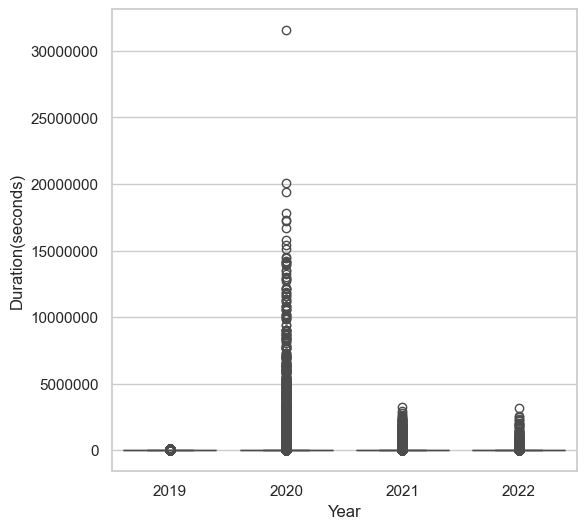

In [181]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'merge_df' is your DataFrame
plt.figure(figsize=(6, 6))
sns.boxplot(x='Year', y='Duration', data=merge_df)

# Disable scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Duration(seconds)')

plt.show()

In [182]:
for year in merge_df.Year.unique():
    if year == min(merge_df.Year.unique()):
        df_year = merge_df[merge_df['Year'] == year]

        # Remove Outliers
        Q1 = df_year['Duration'].quantile(0.25)
        Q3 = df_year['Duration'].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds to identify outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_no_outliers = merge_df[~((merge_df['Year']==year) & ((merge_df['Duration'] <= lower_bound) | (merge_df['Duration'] >= upper_bound)))]
    else:
        df_year = merge_df[merge_df['Year'] == year]

        # Remove Outliers
        Q1 = df_year['Duration'].quantile(0.25)
        Q3 = df_year['Duration'].quantile(0.75)
        IQR = Q3 - Q1

        # Define the lower and upper bounds to identify outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df_no_outliers = df_no_outliers[~((merge_df['Year']==year) & ((merge_df['Duration'] <= lower_bound) | (merge_df['Duration'] >= upper_bound)))]        


C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13920\2847004915.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[~((merge_df['Year']==year) & ((merge_df['Duration'] <= lower_bound) | (merge_df['Duration'] >= upper_bound)))]
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13920\2847004915.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[~((merge_df['Year']==year) & ((merge_df['Duration'] <= lower_bound) | (merge_df['Duration'] >= upper_bound)))]
C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13920\2847004915.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_no_outliers = df_no_outliers[~((merge_df['Year']==year) & ((merge_df['Duration'] <= lower_bound) | (merge_df['Duration'] >= upper_bound)))]


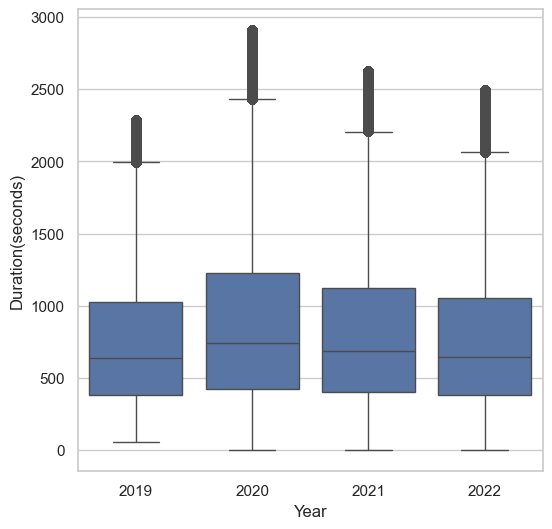

In [183]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'merge_df' is your DataFrame
plt.figure(figsize=(6, 6))
sns.boxplot(x='Year', y='Duration', data=df_no_outliers)

# Disable scientific notation on the y-axis
plt.ticklabel_format(style='plain', axis='y')
plt.ylabel('Duration(seconds)')

plt.show()

## Descriptive Statistics

In [135]:
a = df_no_outliers.groupby(['Year']).agg({'Duration':'sum','start_station_id':'count'}).reset_index()
a['mean'] = a.Duration/a.start_station_id


# Function to convert scientific notation to decimal
def convert_sci_to_decimal(number):
    return "{:.0f}".format(number)

# Apply the function to the desired column
a['Duration'] = a['Duration'].apply(lambda x: convert_sci_to_decimal(x))


new_columns = ['Year','Duration', 'Ride(Count)','Duration(mean)']

# Assign new column names to the DataFrame
a.columns = new_columns
a

Year    Duration  Ride(Count)  Duration(mean)
0  2019  2379330389      3171107          750.32
1  2020  1788247542      1934193          924.54
2  2021  2075064535      2339814          886.85
3  2022  2503433745      3050207          820.74

In [71]:
df_no_outliers.groupby('Year')['Duration'].describe()

count        mean         std   min    25%    50%     75%     max
Year                                                                       
2019  3171107.0  750.315391  469.124577  60.0  380.0  636.0  1027.0  2285.0
2020  2012643.0  888.507074  598.220006   0.0  427.0  742.0  1230.0  2917.0
2021  2522698.0  822.557649  546.618874   0.0  406.0  689.0  1126.0  2632.0
2022  3183237.0  786.442777  536.725341   0.0  386.0  648.0  1058.0  2510.0

In [72]:
pd.set_option('display.float_format', '{:.2f}'.format)
cross_tab = pd.crosstab(index=df_no_outliers['Year'], columns=df_no_outliers['member_casual'],normalize='index')
cross_tab

member_casual  casual  member
Year                         
2019             0.10    0.90
2020             0.33    0.67
2021             0.37    0.63
2022             0.37    0.63

## Hypothesis Testing

### T.test Duration|Member

In [110]:
duration_m = df_no_outliers[df_no_outliers['member_casual']=='member']['Duration']
duration_c = df_no_outliers[df_no_outliers['member_casual']=='casual']['Duration']
member_mean = df_no_outliers[df_no_outliers['member_casual']=='member']['Duration'].mean()
casual_mean = df_no_outliers[df_no_outliers['member_casual']=='casual']['Duration'].mean()

from scipy import stats

# Independent two-sample t-test
t_stat, p_value = stats.ttest_ind(duration_m, duration_c)

# Display the result
print("Member Mean Duration : ", member_mean)
print("Casual Mean Duration : ", casual_mean)
print(f'T-statistic: {t_stat:.10f}')
print(f'P-value: {p_value:.30f}')

Member Mean Duration :  710.1391102552708
Casual Mean Duration :  1037.6919172908017
T-statistic: -948.3039531458
P-value: 0.000000000000000000000000000000


### T.test Duration|Member (Yearly)

In [122]:
for i in range(2019,2023):
    duration_m = df_no_outliers[(df_no_outliers['member_casual']=='member') & (df_no_outliers['Year'] == i)]['Duration']
    duration_c = df_no_outliers[(df_no_outliers['member_casual']=='casual') & (df_no_outliers['Year'] == i)]['Duration']
    member_mean = df_no_outliers[(df_no_outliers['member_casual']=='member') & (df_no_outliers['Year'] == i)]['Duration'].mean()
    casual_mean = df_no_outliers[(df_no_outliers['member_casual']=='casual') & (df_no_outliers['Year'] == i)]['Duration'].mean()

    from scipy import stats

    # Independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(duration_m, duration_c)

    # Display the result
    print(f"Duration testing {i}")
    print("Member Mean Duration : ", member_mean)
    print("Casual Mean Duration : ", casual_mean)
    print(f'T-statistic: {t_stat:.10f}')
    print(f'P-value: {p_value:.30f}')
    print("")


Duration testing 2019
Member Mean Duration :  706.8051580869256
Casual Mean Duration :  1151.2655089326556
T-statistic: -522.5065999620
P-value: 0.000000000000000000000000000000

Duration testing 2020
Member Mean Duration :  756.2917174932938
Casual Mean Duration :  1155.9983777548127
T-statistic: -469.8007640537
P-value: 0.000000000000000000000000000000

Duration testing 2021
Member Mean Duration :  708.4943655510165
Casual Mean Duration :  1018.8490588423092
T-statistic: -452.0485809585
P-value: 0.000000000000000000000000000000

Duration testing 2022
Member Mean Duration :  685.0668944502081
Casual Mean Duration :  956.4866722290163
T-statistic: -450.1210059029
P-value: 0.000000000000000000000000000000


### Chi square Year|Member

In [119]:
import pandas as pd
from scipy.stats import chi2_contingency

cross_tab = pd.crosstab(index=df_no_outliers['Year'], columns=df_no_outliers['member_casual'])

# Performing a chi-square test
chi2, p, dof, expected = chi2_contingency(cross_tab)

# Displaying the results
print("Year|Member Table")
print(cross_tab)
print("")
print(f"Chi-square statistic: {chi2}")
print(f"P-value: {p}")
print("Expected frequencies:")
print(expected)

Year|Member Table
member_casual   casual   member
Year                           
2019            310434  2860673
2020            665744  1346899
2021            927156  1595542
2022           1188946  1994291

Chi-square statistic: 773802.371502223
P-value: 0.0
Expected frequencies:
[[ 900480.66164999 2270626.33835001]
 [ 571518.4319877  1441124.5680123 ]
 [ 716355.7597341  1806342.2402659 ]
 [ 903925.14662821 2279311.85337179]]


### T.test Member|Hour

In [120]:
duration_m = df_no_outliers[df_no_outliers['member_casual']=='member']['Hour']
duration_c = df_no_outliers[df_no_outliers['member_casual']=='casual']['Hour']

member_mean = df_no_outliers[df_no_outliers['member_casual']=='member']['Hour'].mean()
casual_mean = df_no_outliers[df_no_outliers['member_casual']=='casual']['Hour'].mean()

from scipy import stats

# Independent two-sample t-test
t_stat, p_value = stats.ttest_ind(duration_m, duration_c)

# Display the result
print("Member Mean Hours : ", member_mean)
print("Casual Mean Hours : ", casual_mean)

print(f'T-statistic: {t_stat:.10f}')
print(f'P-value: {p_value:.30f}')

Member Mean Hours :  13.894269952631676
Casual Mean Hours :  14.493881537247598
T-statistic: -184.7718997571
P-value: 0.000000000000000000000000000000


### T.test Member|Hour (Yearly)

In [124]:
for i in range(2019,2023):
    duration_m = df_no_outliers[(df_no_outliers['member_casual']=='member') & (df_no_outliers['Year'] == i)]['Hour']
    duration_c = df_no_outliers[(df_no_outliers['member_casual']=='casual') & (df_no_outliers['Year'] == i)]['Hour']
    member_mean = df_no_outliers[(df_no_outliers['member_casual']=='member') & (df_no_outliers['Year'] == i)]['Hour'].mean()
    casual_mean = df_no_outliers[(df_no_outliers['member_casual']=='casual') & (df_no_outliers['Year'] == i)]['Hour'].mean()

    from scipy import stats

    # Independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(duration_m, duration_c)

    # Display the result
    print(f"Hour Difference Testing {i}")
    print("Member Mean Duration : ", member_mean)
    print("Casual Mean Duration : ", casual_mean)
    print(f'T-statistic: {t_stat:.10f}')
    print(f'P-value: {p_value:.30f}')
    print("")


Hour Difference Testing 2019
Member Mean Duration :  13.646487382514534
Casual Mean Duration :  14.528869260454718
T-statistic: -95.6752329605
P-value: 0.000000000000000000000000000000

Hour Difference Testing 2020
Member Mean Duration :  13.945640318984571
Casual Mean Duration :  14.672127724771084
T-statistic: -105.7669613119
P-value: 0.000000000000000000000000000000

Hour Difference Testing 2021
Member Mean Duration :  14.071411470208869
Casual Mean Duration :  14.38851606417906
T-statistic: -50.0514408261
P-value: 0.000000000000000000000000000000

Hour Difference Testing 2022
Member Mean Duration :  14.073279676837533
Casual Mean Duration :  14.467103636329993
T-statistic: -69.3911786482
P-value: 0.000000000000000000000000000000



### T.test Distance|Member

In [165]:
duration_m = df_no_outliers[df_no_outliers['member_casual']=='member']['distance']
duration_c = df_no_outliers[df_no_outliers['member_casual']=='casual']['distance']

member_mean = df_no_outliers[df_no_outliers['member_casual']=='member']['distance'].mean()
casual_mean = df_no_outliers[df_no_outliers['member_casual']=='casual']['distance'].mean()

from scipy import stats

# Independent two-sample t-test
t_stat, p_value = stats.ttest_ind(duration_m, duration_c)

# Display the result
print("Member Mean Hours : ", member_mean)
print("Casual Mean Hours : ", casual_mean)

print(f'T-statistic: {t_stat:.10f}')
print(f'P-value: {p_value:.30f}')

Member Mean Hours :  1.131606281526995
Casual Mean Hours :  1.2026891000323163
T-statistic: -41.5667142940
P-value: 0.000000000000000000000000000000


### T.test Distance|Member(Yearly)

In [184]:
for i in range(2019,2023):
    duration_m = df_no_outliers[(df_no_outliers['member_casual']=='member') & (df_no_outliers['Year'] == i)]['distance']
    duration_c = df_no_outliers[(df_no_outliers['member_casual']=='casual') & (df_no_outliers['Year'] == i)]['distance']
    member_mean = df_no_outliers[(df_no_outliers['member_casual']=='member') & (df_no_outliers['Year'] == i)]['distance'].mean()
    casual_mean = df_no_outliers[(df_no_outliers['member_casual']=='casual') & (df_no_outliers['Year'] == i)]['distance'].mean()

    from scipy import stats

    # Independent two-sample t-test
    t_stat, p_value = stats.ttest_ind(duration_m, duration_c)

    # Display the result
    print(f"Distance Difference Testing {i}")
    print("Member Mean Duration : ", member_mean)
    print("Casual Mean Duration : ", casual_mean)
    print(f'T-statistic: {t_stat:.10f}')
    print(f'P-value: {p_value:.30f}')
    print("")


Distance Difference Testing 2019
Member Mean Duration :  1.0910735693959963
Casual Mean Duration :  1.0519490604310209
T-statistic: 28.6286413251
P-value: 0.000000000000000000000000000000

Distance Difference Testing 2020
Member Mean Duration :  1.1473874721844302
Casual Mean Duration :  1.2631473130770035
T-statistic: -19.3117739909
P-value: 0.000000000000000000000000000000

Distance Difference Testing 2021
Member Mean Duration :  1.1302872447974477
Casual Mean Duration :  1.2025651504160397
T-statistic: -64.9833722488
P-value: 0.000000000000000000000000000000

Distance Difference Testing 2022
Member Mean Duration :  1.1106918189808965
Casual Mean Duration :  1.1658051189052236
T-statistic: -58.9321792040
P-value: 0.000000000000000000000000000000



In [174]:
duration_m = df_no_outliers[(df_no_outliers['member_casual']=='member') & (df_no_outliers['Year'] == 2019)]['distance']
duration_c = df_no_outliers[(df_no_outliers['member_casual']=='casual') & (df_no_outliers['Year'] == 2019)]['distance']
member_mean = df_no_outliers[(df_no_outliers['member_casual']=='member') & (df_no_outliers['Year'] == 2019)]['distance'].mean()
casual_mean = df_no_outliers[(df_no_outliers['member_casual']=='casual') & (df_no_outliers['Year'] == 2019)]['distance'].mean()

from scipy import stats

# Independent two-sample t-test
t_stat, p_value = stats.ttest_ind(duration_m, duration_c)

# Display the result
print(f"Distance Difference Testing {2019}")
print("Member Mean Duration : ", member_mean)
print("Casual Mean Duration : ", casual_mean)
print(f'T-statistic: {t_stat:.10f}')
print(f'P-value: {p_value:.30f}')
print("")

Distance Difference Testing 2019
Member Mean Duration :  nan
Casual Mean Duration :  nan
T-statistic: nan
P-value: nan



# EDA

/var/folders/4f/565zs95x5xb988rb96g8px_40000gn/T/ipykernel_6204/4073051603.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=sum, ci=None)
/Users/jackyzhang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackyzhang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jackyzhang/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(

<Axes: xlabel='Month', ylabel='Duration'>

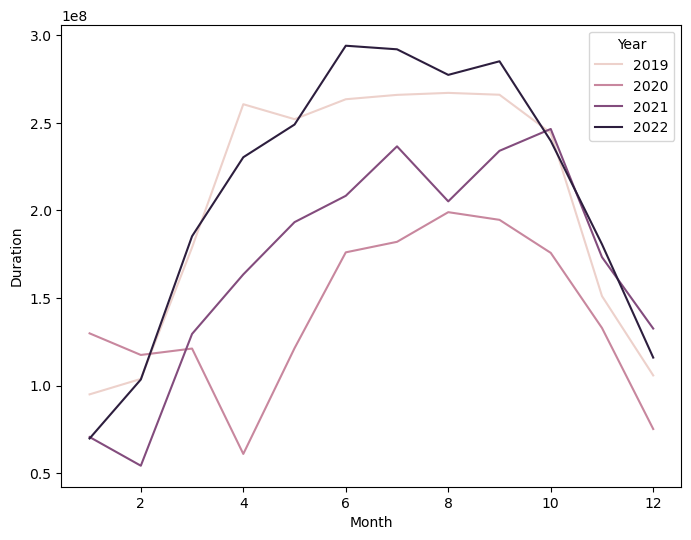

In [ ]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.lineplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=sum, ci=None)

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13920\3586413024.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=sum, ci=None)


<Axes: xlabel='Month', ylabel='Duration'>

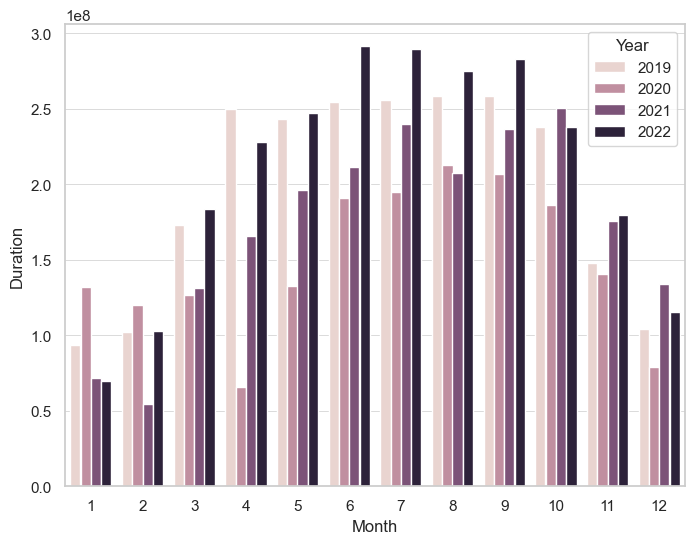

In [81]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.barplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=sum, ci=None)

C:\Users\JaeHoBahng\AppData\Local\Temp\ipykernel_13920\2832672741.py:6: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=np.mean, ci=None)


<Axes: xlabel='Month', ylabel='Duration'>

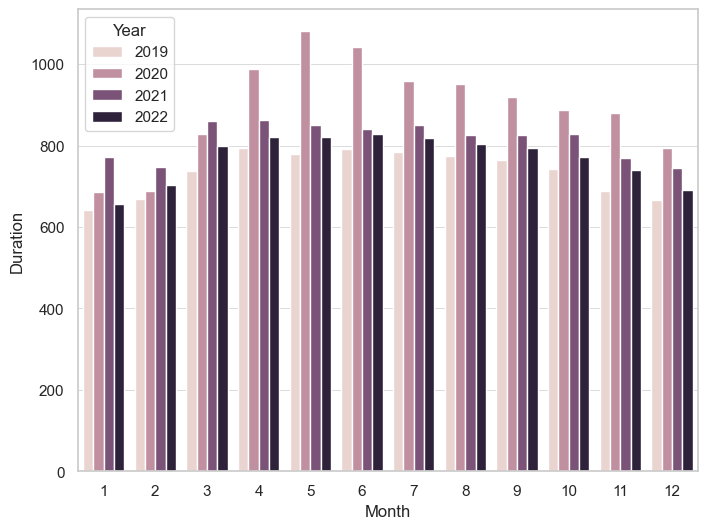

In [82]:
import seaborn as sns
from scipy.stats.mstats import gmean
import numpy as np

plt.figure(figsize=(8, 6))
sns.barplot(x='Month', y='Duration', hue='Year', data=df_no_outliers, estimator=np.mean, ci=None)

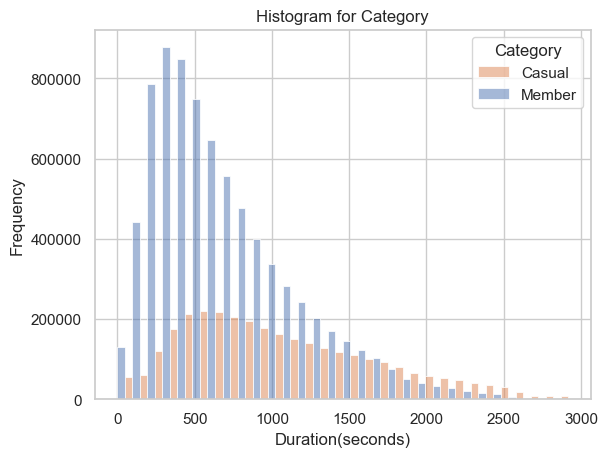

In [83]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for seaborn (optional)
sns.set(style="whitegrid")

# Create a new figure for each category
plt.figure()

# Use Seaborn's histplot to create the histogram
sns.histplot(data=df_no_outliers, x='Duration', hue='member_casual', bins=30,
             alpha=0.5, multiple='dodge')

plt.xlabel('Duration(seconds)')
plt.ylabel('Frequency')
plt.title('Histogram for Category')

# Display the legend with explicit labels
plt.legend(title='Category', labels=['Casual', 'Member'])

# Display the plot
plt.show()


Text(0.5, 1.0, 'Histogram for Category 2019')

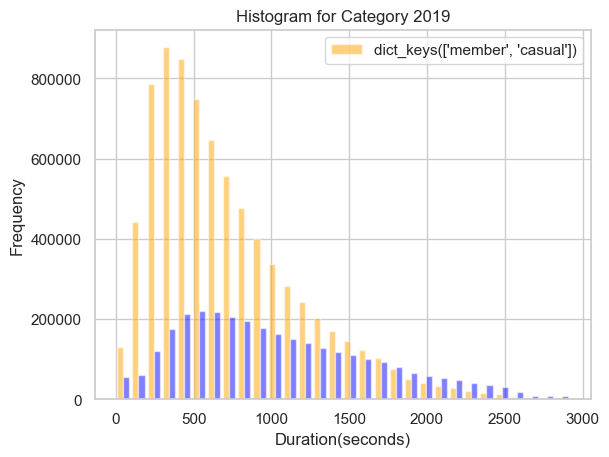

In [84]:
colors = {'member': 'orange', 'casual': 'blue'}
plt.figure()  # Create a new figure for each category

unique_categories = df_no_outliers['member_casual'].unique()
plt.hist([df_no_outliers[df_no_outliers['member_casual'] == cat]['Duration'] for cat in unique_categories],
        bins=30, alpha=0.5, color=[colors[cat] for cat in unique_categories], label=colors.keys())
plt.legend()
plt.xlabel('Duration(seconds)')
plt.ylabel('Frequency')
plt.title(f'Histogram for Category {category}')

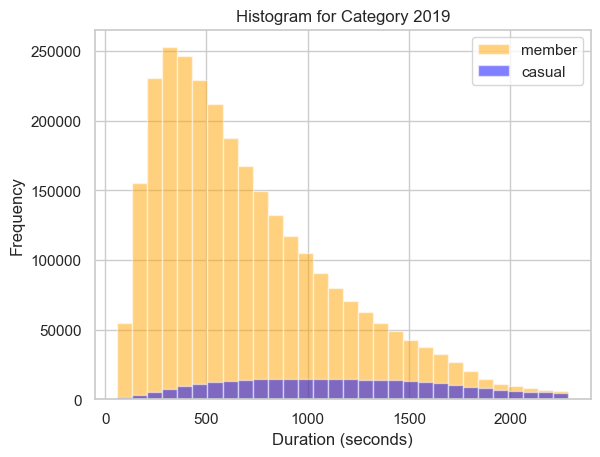

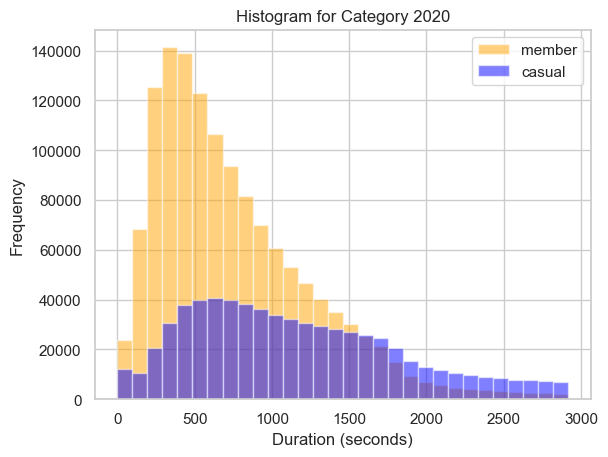

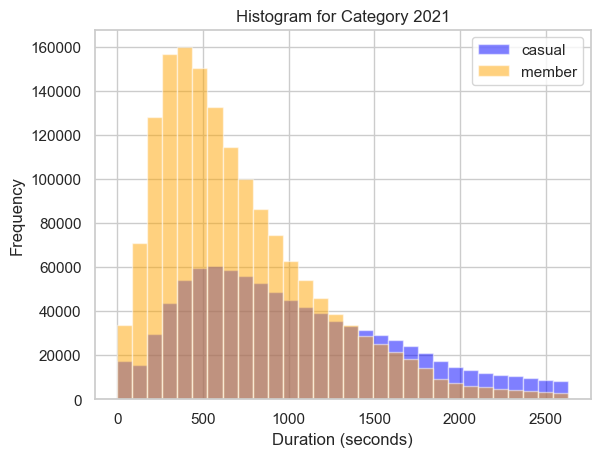

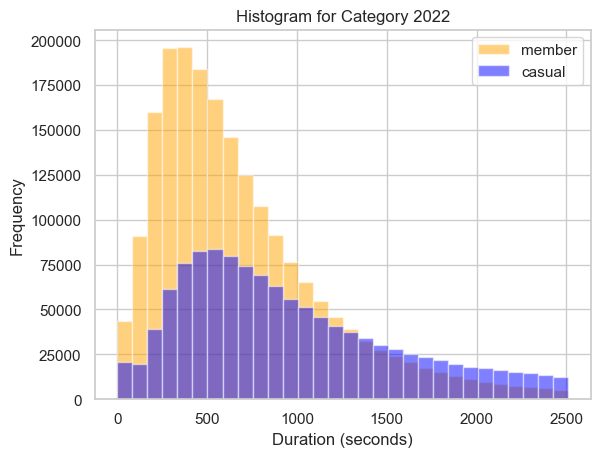

In [87]:
import matplotlib.pyplot as plt

colors = {'member': 'orange', 'casual': 'blue'}

for category in df_no_outliers['Year'].unique():
    plt.figure()  # Create a new figure for each category
    subset_df = df_no_outliers[df_no_outliers['Year'] == category]

    unique_categories = subset_df['member_casual'].unique()

    for cat in unique_categories:
        plt.hist(subset_df[subset_df['member_casual'] == cat]['Duration'],
                 bins=30, alpha=0.5, color=colors[cat], label=cat)

    plt.xlabel('Duration (seconds)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.title(f'Histogram for Category {category}')

plt.show()


In [88]:
subset_df = df_no_outliers[df_no_outliers['Year'] == 2021]
subset_df.groupby(['member_casual']).agg({'Duration':'mean','start_station_id':'count'}).reset_index()

member_casual  Duration  start_station_id
0        casual   1018.85            838538
1        member    708.49           1501276

In [89]:
id_count = merge_df.groupby(['Year','start_station_id']).size().reset_index(name='Count')

map_df = pd.merge(id_count, station_index, on='start_station_id')
map_df.head()

Year start_station_id  Count  start_lat  start_lng
0  2019         31000.00   1563      38.86     -77.05
1  2020         31000.00   1327      38.86     -77.05
2  2021         31000.00   1520      38.86     -77.05
3  2022         31000.00   2630      38.86     -77.05
4  2019         31001.00   1993      38.86     -77.05

In [90]:
import folium
from IPython.display import display

for i in list(map_df.Year.unique()):
    subset_df = map_df[map_df['Year'] == i]

    latitudes = list(subset_df['start_lat'])
    longitudes = list(subset_df['start_lng'])
    size = list(subset_df['Count'])

    # Create a folium map centered at the average location
    map_center = [sum(latitudes) / len(latitudes), sum(longitudes) / len(longitudes)]
    my_map = folium.Map(location=map_center, zoom_start=12.5)

    # Add markers for latitude and longitude points
    for lat, lon, size in zip(latitudes, longitudes, size):
        folium.CircleMarker(location=[lat, lon], radius=size / 2000, popup=f"Lat: {lat}, Lon: {lon}", fill=True).add_to(my_map)

    # Display the map
    display(my_map)
